# Training a convnet from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs). We’ll use 2,000 pictures for training, 1,000 for validation, and 2,000 for testing.

In [1]:
!git clone https://github.com/octavio-navarro/DL_Data_sets

Cloning into 'DL_Data_sets'...
remote: Enumerating objects: 59481, done.
remote: Counting objects: 100% (20181/20181), done.
remote: Compressing objects: 100% (20170/20170), done.
remote: Total 59481 (delta 9), reused 20180 (delta 8), pack-reused 39300
Receiving objects: 100% (59481/59481), 767.43 MiB | 40.90 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Checking out files: 100% (59380/59380), done.


In [ ]:
!ls
!ls DL_Data_sets/Dogs_vs_cats/training_set/cats/

DL_Data_sets  sample_data
cat.1000.jpg  cat.1721.jpg  cat.2441.jpg  cat.3161.jpg	cat.3882.jpg
cat.1001.jpg  cat.1722.jpg  cat.2442.jpg  cat.3162.jpg	cat.3883.jpg
cat.1002.jpg  cat.1723.jpg  cat.2443.jpg  cat.3163.jpg	cat.3884.jpg
cat.1003.jpg  cat.1724.jpg  cat.2444.jpg  cat.3164.jpg	cat.3885.jpg
cat.1004.jpg  cat.1725.jpg  cat.2445.jpg  cat.3165.jpg	cat.3886.jpg
cat.1005.jpg  cat.1726.jpg  cat.2446.jpg  cat.3166.jpg	cat.3887.jpg
cat.1006.jpg  cat.1727.jpg  cat.2447.jpg  cat.3167.jpg	cat.3888.jpg
cat.1007.jpg  cat.1728.jpg  cat.2448.jpg  cat.3168.jpg	cat.3889.jpg
cat.1008.jpg  cat.1729.jpg  cat.2449.jpg  cat.3169.jpg	cat.388.jpg
cat.1009.jpg  cat.172.jpg   cat.244.jpg   cat.316.jpg	cat.3890.jpg
cat.100.jpg   cat.1730.jpg  cat.2450.jpg  cat.3170.jpg	cat.3891.jpg
cat.1010.jpg  cat.1731.jpg  cat.2451.jpg  cat.3171.jpg	cat.3892.jpg
cat.1011.jpg  cat.1732.jpg  cat.2452.jpg  cat.3172.jpg	cat.3893.jpg
cat.1012.jpg  cat.1733.jpg  cat.2453.jpg  cat.3173.jpg	cat.3894.jpg
cat.1013.jpg  cat.1734.j

What qualifies as “enough samples” to train a model is relative—relative to the size and depth of the model you’re trying to train, for starters. It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple.

Because convnets learn local, translation-invariant features, they’re highly data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will yield reasonable results despite a relative lack of data, without the need for any custom feature engineering.

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

(320, 500, 3)


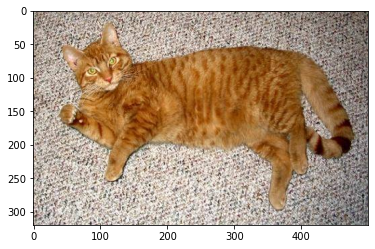

In [ ]:
cat_image = cv2.imread('DL_Data_sets/Dogs_vs_cats/training_set/cats/cat.997.jpg')
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)

print(cat_image.shape)
plt.imshow(cat_image)

### Data preparation

Data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

1. Read the images.
2. Resize the images.
3. Convert to tensors and normalize the data.
4. Pack them in batches.

Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function **ImageDataGenerator**, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors.


In [ ]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    'DL_Data_sets/Dogs_vs_cats/training_set',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'
)

validation_generator = train_data_gen.flow_from_directory(
    'DL_Data_sets/Dogs_vs_cats/training_set',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation'
)

test_generator = test_data_gen.flow_from_directory(
    'DL_Data_sets/Dogs_vs_cats/test_set',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


We can visualize the images from the generator with the following code:

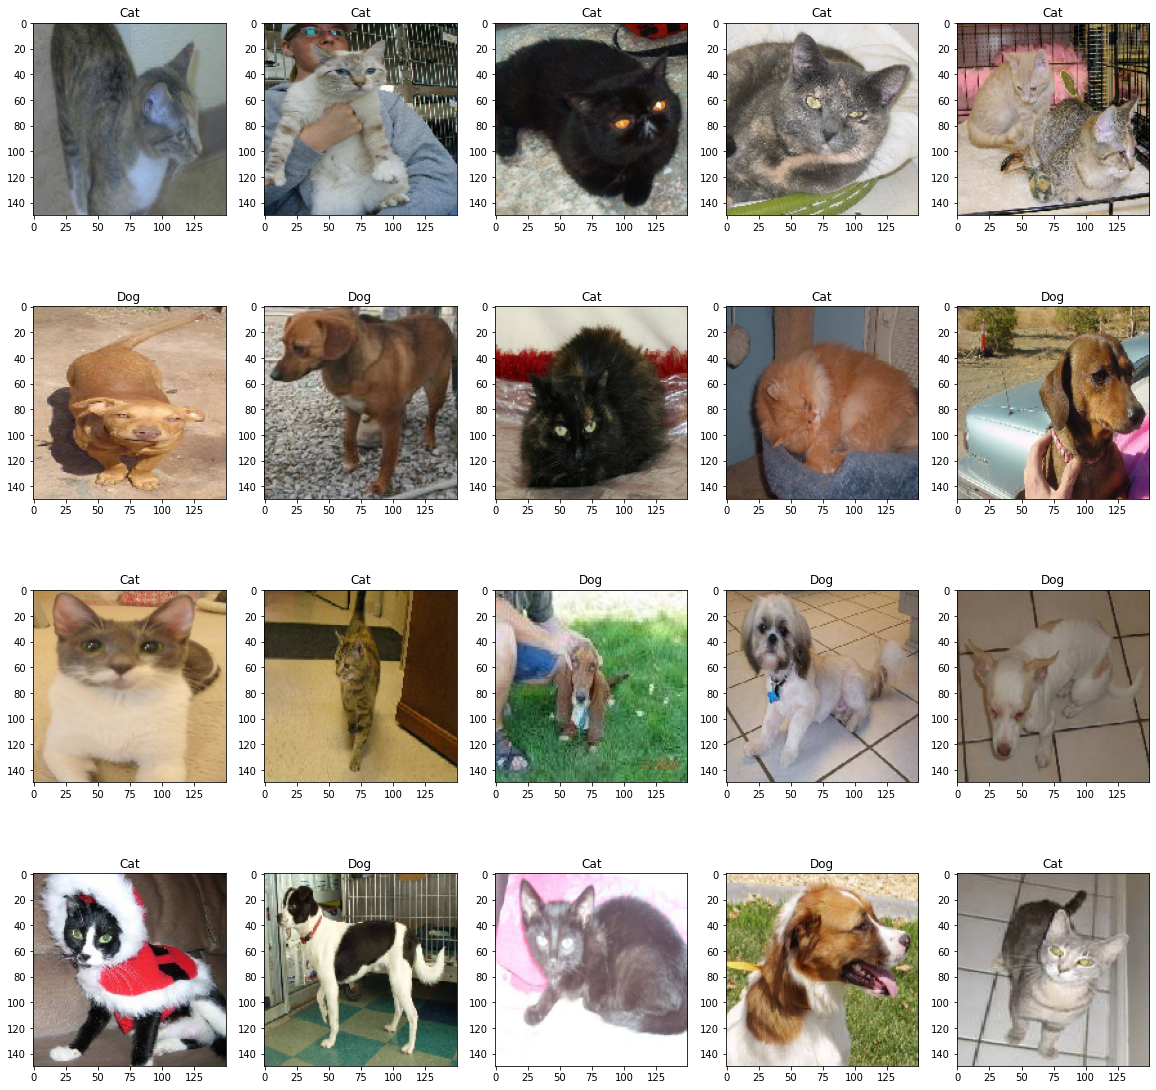

In [ ]:
(imgs, labels) = test_generator.next()

batch_size = 20
imgs_per_row = 5

f, plots = plt.subplots((batch_size+imgs_per_row-1)//imgs_per_row, imgs_per_row, figsize=(20,20))
plots = [plot for sublist in plots for plot in sublist]

for img, label, plot in zip(imgs, labels, plots):
    plot.set_title("Cat" if label == 0 else "Dog")
    plot.imshow(img, cmap='gray')

### Building the model

We will use the same general model structure you saw in the first example: the convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

But because we’re dealing with bigger images and a more complex problem, we’ll
make our model larger, accordingly: it will have two more Conv2D and maxPooling2D stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the Flatten layer.

Here, because we start from inputs of size 150 pixels × 150 pixels (a somewhat arbitrary choice), we end up with feature maps of size 7 × 7 just before the Flatten layer.

In [ ]:
network = models.Sequential()

network.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(64, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(128, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(128, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Flatten())

network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.summary()

network.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
history = network.fit(
    train_generator,
    epochs=30,
    validation_data = validation_generator
)

Epoch 1/30
320/320 [==============================] - 36s 73ms/step - loss: 0.6649 - accuracy: 0.5855 - val_loss: 0.6323 - val_accuracy: 0.6275
Epoch 2/30
320/320 [==============================] - 24s 75ms/step - loss: 0.5850 - accuracy: 0.6811 - val_loss: 0.6326 - val_accuracy: 0.6488
Epoch 3/30
320/320 [==============================] - 24s 74ms/step - loss: 0.5370 - accuracy: 0.7261 - val_loss: 0.5453 - val_accuracy: 0.7169
Epoch 4/30
320/320 [==============================] - 24s 75ms/step - loss: 0.5013 - accuracy: 0.7545 - val_loss: 0.5419 - val_accuracy: 0.7287
Epoch 5/30
320/320 [==============================] - 24s 75ms/step - loss: 0.4683 - accuracy: 0.7752 - val_loss: 0.4883 - val_accuracy: 0.7563
Epoch 6/30
320/320 [==============================] - 23s 73ms/step - loss: 0.4407 - accuracy: 0.7942 - val_loss: 0.4626 - val_accuracy: 0.7794
Epoch 7/30
320/320 [==============================] - 24s 74ms/step - loss: 0.4115 - accuracy: 0.8167 - val_loss: 0.4807 - val_accuracy:

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

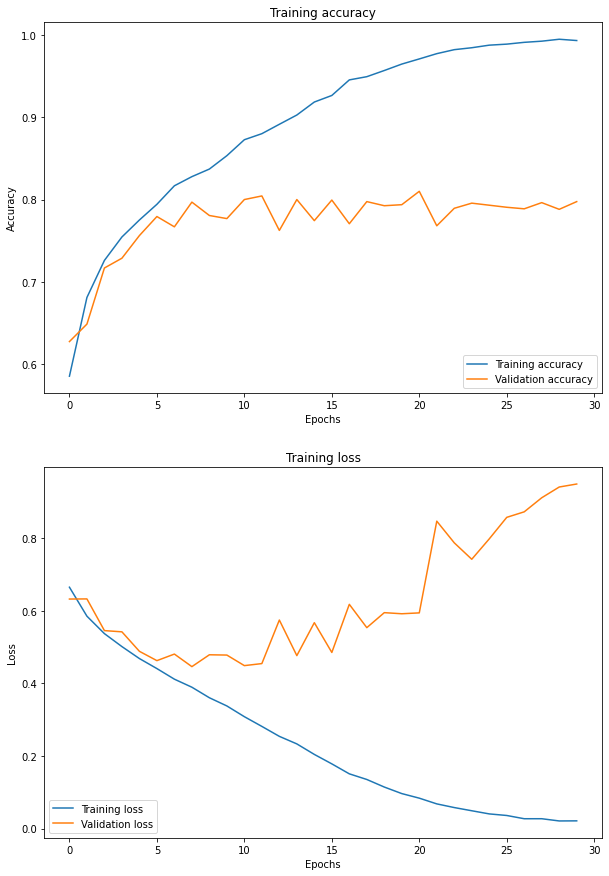

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].plot(acc_values, label="Training accuracy")
ax[0].plot(val_acc_values, label="Validation accuracy")
ax[0].set_title("Training accuracy")
ax[0].legend(loc='lower right')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].plot(loss_values, label="Training loss")
ax[1].plot(val_loss_values, label="Validation loss")
ax[1].set_title("Training loss")
ax[1].legend(loc='lower left')

## Data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data so it can generalize better.

In [29]:
def gray_scale(image):
  '''
  image is rgb
  '''
  img_hsv = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
  (h, s, v) = cv2.split(img_hsv)
  v_eq = cv2.equalizeHist(v)
  img_eq = cv2.merge([h, s, v_eq])
  return cv2.cvtColor(img_eq, cv2.COLOR_HSV2RGB).astype('float64')

In [30]:
augmented_data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    # fill_mode = 'nearest',
    validation_split = 0.2,
    preprocessing_function = gray_scale
)

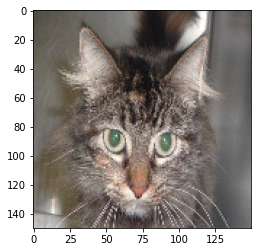

In [22]:
data_test_dir = 'DL_Data_sets/Dogs_vs_cats/training_set/cats/'
img_path = data_test_dir + 'cat.3141.jpg'

cat_image = cv2.imread(img_path)
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)
cat_image = cv2.resize(cat_image, dsize=(150, 150))

plt.imshow(cat_image)

(1, 150, 150, 3)
(150, 150)
(150, 150)
(150, 150)


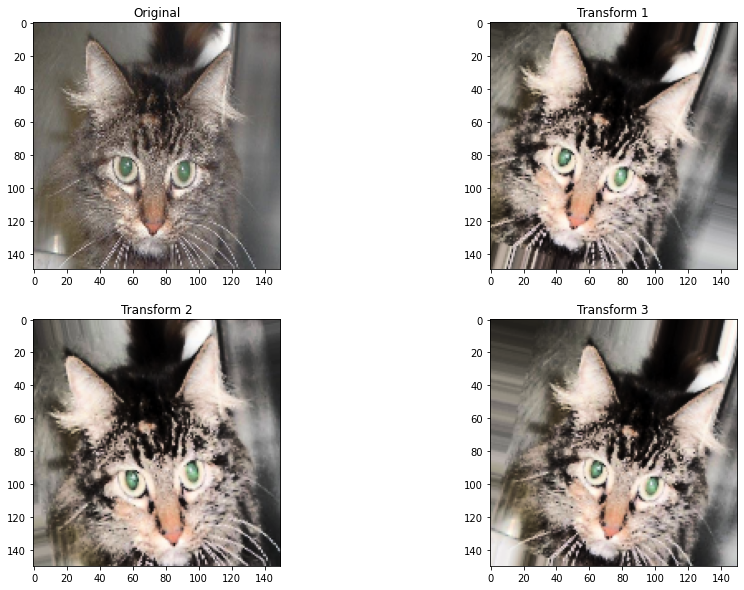

In [26]:
cat_tensor = np.reshape(cat_image, (1, 150, 150, 3))
print(cat_tensor.shape)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.title('Original')
plt.imshow(cat_image)

idx = 1
for batch in augmented_data_gen.flow(cat_tensor, batch_size=1):
  plt.subplot(2, 2, idx+1)
  plt.title(f'Transform {idx}')
  plt.imshow(batch[0])
  idx += 1

  if idx % 4 == 0:
    break

plt.show()

If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting.

To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier.

The Dropout layer randomly sets input units to 0 with a frequency of *rate* at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by $1/(1 - rate)$ such that the sum over all inputs is unchanged.

In [ ]:
network = models.Sequential()

network.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(64, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(128, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(128, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Flatten())

network.add(layers.Dropout(0.5))

network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dropout(0.5))

network.add(layers.Dense(1, activation='sigmoid'))

network.summary()

network.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [31]:
train_generator = augmented_data_gen.flow_from_directory(
    'DL_Data_sets/Dogs_vs_cats/training_set',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'
)

validation_generator = augmented_data_gen.flow_from_directory(
    'DL_Data_sets/Dogs_vs_cats/training_set',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation'
)

test_gen_aug = augmented_data_gen.flow_from_directory(
    'DL_Data_sets/Dogs_vs_cats/test_set',
    target_size=(150, 150),
    batch_size=20,
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


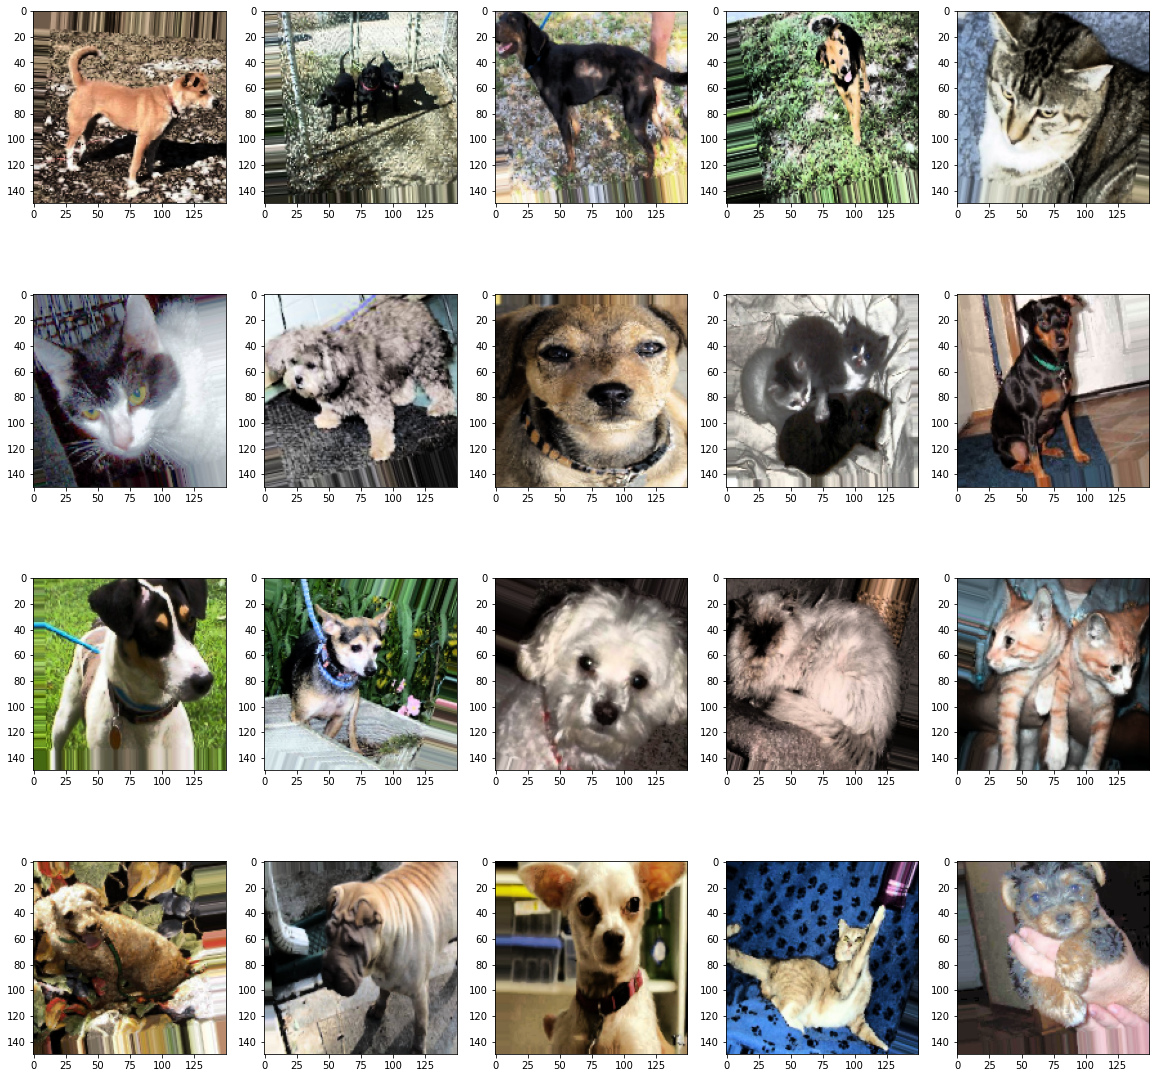

In [33]:
(imgs, labels) = test_gen_aug.next()

batch_size = 20
imgs_per_row = 5

f, plots = plt.subplots((batch_size+imgs_per_row-1)//imgs_per_row, imgs_per_row, figsize=(20,20))
plots = [plot for sublist in plots for plot in sublist]

for img, label, plot in zip(imgs, labels, plots):
    plot.imshow(img)

In [ ]:
history = network.fit(
    train_generator,
    epochs=30,
    validation_data = validation_generator
)

Epoch 1/30
320/320 [==============================] - 58s 178ms/step - loss: 0.6883 - accuracy: 0.5311 - val_loss: 0.6664 - val_accuracy: 0.5838
Epoch 2/30
320/320 [==============================] - 58s 181ms/step - loss: 0.6534 - accuracy: 0.6028 - val_loss: 0.6205 - val_accuracy: 0.6431
Epoch 3/30
320/320 [==============================] - 57s 177ms/step - loss: 0.6231 - accuracy: 0.6486 - val_loss: 0.5861 - val_accuracy: 0.6994
Epoch 4/30
320/320 [==============================] - 57s 179ms/step - loss: 0.5892 - accuracy: 0.6778 - val_loss: 0.5636 - val_accuracy: 0.7150
Epoch 5/30
320/320 [==============================] - 56s 177ms/step - loss: 0.5709 - accuracy: 0.6969 - val_loss: 0.5388 - val_accuracy: 0.7163
Epoch 6/30
320/320 [==============================] - 58s 180ms/step - loss: 0.5535 - accuracy: 0.7158 - val_loss: 0.5399 - val_accuracy: 0.7306
Epoch 7/30
320/320 [==============================] - 57s 177ms/step - loss: 0.5368 - accuracy: 0.7322 - val_loss: 0.5109 - val_ac

In [ ]:
def smooth_curve(points, factor=0.8): 
  smoothed_points = [] 
  for point in points: 
    if smoothed_points: 
      previous = smoothed_points[-1] 
      smoothed_points.append(previous * factor + point * (1 - factor)) 
    else: 
      smoothed_points.append(point) 
  
  return smoothed_points 

In [ ]:
history_dict = history.history

loss_values = smooth_curve(history_dict['loss'])
val_loss_values = smooth_curve(history_dict['val_loss'])

acc_values = smooth_curve(history_dict['accuracy'])
val_acc_values = smooth_curve(history_dict['val_accuracy'])

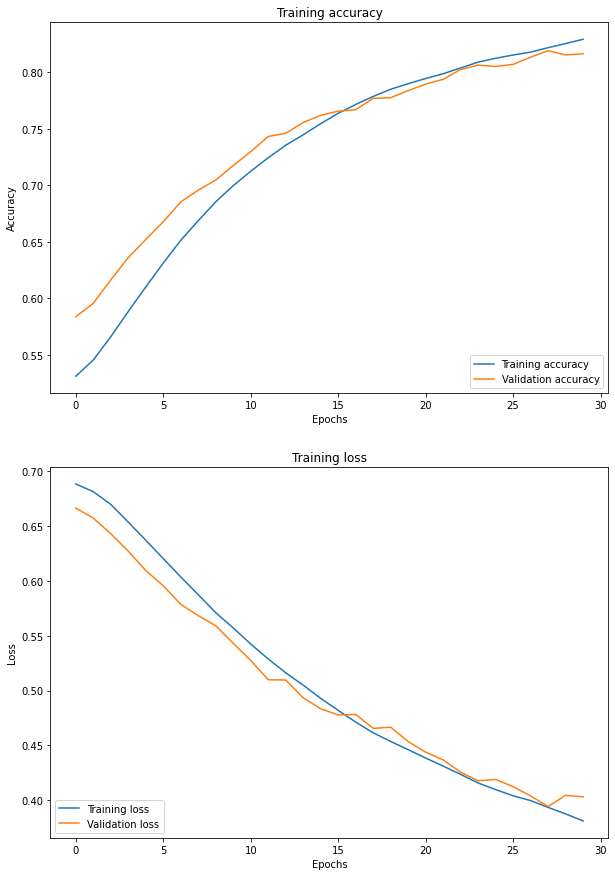

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].plot(acc_values, label="Training accuracy")
ax[0].plot(val_acc_values, label="Validation accuracy")
ax[0].set_title("Training accuracy")
ax[0].legend(loc='lower right')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].plot(loss_values, label="Training loss")
ax[1].plot(val_loss_values, label="Validation loss")
ax[1].set_title("Training loss")
ax[1].legend(loc='lower left')